# Sigmoid Curve, Fitting

## Parameterization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from ipywidgets import interact

plt.style.use('ggplot')
random.seed(37)
np.random.seed(37)

def logistic(x, x_0=0.0, k=1.0, L=1.0):
    return L / (1 + np.exp(-k*(x - x_0)))

x = np.linspace(-11, 11, 100)

s1 = pd.Series(logistic(x), index=x)
s2 = pd.Series(logistic(x, x_0=-3), index=x)
s3 = pd.Series(logistic(x, x_0=3), index=x)

@interact(x_0=(-4, 4, 1), k=(0.65, 1.5, 0.01))
def f(x_0=4, k=1.5):
    s4 = pd.Series(logistic(x, x_0=x_0, k=k), index=x)
    fig, ax = plt.subplots(figsize=(15, 3))

    _ = s1.plot(ax=ax, alpha=0.2, color='red')
    _ = s2.plot(ax=ax, alpha=0.2, color='green')
    _ = s3.plot(ax=ax, alpha=0.2, color='blue')
    _ = s4.plot(ax=ax, color='magenta')

    _ = ax.set_yticks(np.linspace(0, 1, 11))
    _ = ax.set_xticks(np.arange(-11, 12))

interactive(children=(IntSlider(value=4, description='x_0', max=4, min=-4), FloatSlider(value=1.5, description…

## Fitting with noisy observations

Curve fiting with x-axis untouched and noise is ok. We can get pretty close.

In [2]:
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error, mean_absolute_error

@interact(x_0=(-4, 4, 1), k=(0.65, 1.5, 0.01), noise=(0.01, 0.25, 0.01))
def f(x_0=0, k=1.0, noise=0.05):
    y_true = logistic(x, x_0=x_0, k=k)
    y_obsv = y_true + np.random.normal(0, noise, size=len(x))
    y_obsv = np.array([max(min(v, 1.0), 0.0) for v in y_obsv])
    
    x_e = np.median(x)
    k_e = 1.0
    L_e = y_obsv.max()
    
    p_0 = [x_e, k_e, L_e]
    popt, pcov = curve_fit(logistic, x, y_obsv, method='dogbox')
    y_pred = logistic(x, x_0=popt[0], k=popt[1], L=1.0)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    s1 = pd.Series(y_true, index=x)
    s2 = pd.Series(y_obsv, index=x)
    s3 = pd.Series(y_pred, index=x)
    
    fig, ax = plt.subplots(figsize=(15, 3))

    _ = s1.plot(ax=ax, color='red', alpha=0.5, label='true')
    _ = s2.plot(ax=ax, color='green', label='obsv')
    _ = s3.plot(ax=ax, color='blue', label='pred')

    _ = ax.set_yticks(np.linspace(0, 1, 11))
    _ = ax.set_xticks(np.arange(-11, 12))
    _ = ax.legend()
    _ = ax.set_title(fr'$x_0$={popt[0]:.2f}, $k$={popt[1]:.2f}, $L$={popt[2]:.2f}' + 
                     '\n' +
                     f'MAE={mae:.2f}, RMSE={rmse:.2f}')

interactive(children=(IntSlider(value=0, description='x_0', max=4, min=-4), FloatSlider(value=1.0, description…

## Fitting with partial observations

Partial observations break down before you hit the 50% (x-axis, time) mark.

In [3]:
@interact(x_0=(-4, 4, 1), k=(0.65, 1.5, 0.01), noise=(0.01, 0.25, 0.01), n_obs=(10, 90))
def f(x_0=0, k=1.0, noise=0.05, n_obs=50):
    y_true = logistic(x, x_0=x_0, k=k)
    y_obsv = y_true + np.random.normal(0, noise, size=len(x))
    y_obsv = np.array([max(min(v, 1.0), 0.0) for v in y_obsv])
    
    x_e = np.median(x[:n_obs])
    k_e = 1.0
    L_e = 1.0
    
    p_0 = [x_e, k_e, L_e]
    popt, pcov = curve_fit(logistic, x[:n_obs], y_obsv[:n_obs], p_0, method='dogbox', maxfev=10000)
    y_pred = logistic(x, x_0=popt[0], k=popt[1], L=1.0)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    s1 = pd.Series(y_true, index=x)
    s2 = pd.Series(y_obsv, index=x)
    s3 = pd.Series(y_pred, index=x)
    
    fig, ax = plt.subplots(figsize=(15, 3))

    _ = s1.plot(ax=ax, color='red', alpha=0.5, label='true')
    _ = s2.plot(ax=ax, color='green', label='obsv')
    _ = s3.plot(ax=ax, color='blue', label='pred')

    _ = ax.set_yticks(np.linspace(0, 1, 11))
    _ = ax.set_xticks(np.arange(-11, 12))
    _ = ax.legend()
    _ = ax.set_title(fr'$x_0$={popt[0]:.2f}, $k$={popt[1]:.2f}, $L$={popt[2]:.2f}' + 
                     '\n' +
                     f'MAE={mae:.2f}, RMSE={rmse:.2f}')

interactive(children=(IntSlider(value=0, description='x_0', max=4, min=-4), FloatSlider(value=1.0, description…

## Kalman filtering

The `g-h-k` filter is good, but this is estimating only 1-time step into the future. How can we extrapolate or forecast until the end?

In [4]:
y_true = logistic(x, x_0=0, k=1)
y_obsv = y_true + np.random.normal(0, 0.02, size=len(x))
y_obsv = np.array([max(min(v, 1.0), 0.0) for v in y_obsv])
    
mea = y_obsv
data = []
itr = []

a = 0.4
b = 0.4
c = 0.1
t = 1

# initialization
p_ii = 0
v_ii = 0
a_ii = 0

# State Extrapolation Equations
p_ji = p_ii + (t * v_ii) + (0.5 * a_ii * t**2)
v_ji = v_ii + (a_ii * t)
a_ji = a_ii

itr.append(0)
data.append({
    'pos_e': p_ii, 
    'vel_e': v_ii, 
    'acc_e': a_ii,
    'pos_p': p_ji, 
    'vel_p': v_ji, 
    'acc_p': a_ji,
    'pos_m': p_ii
})

for i, z_i in enumerate(mea):
    # State Update Equations
    dx = z_i - p_ji
    p_ii = p_ji + a * dx
    v_ii = v_ji + b * (dx / t)
    a_ii = a_ji + c * (dx / 0.5 / t**2)
    
    # State Extrapolation Equations
    p_ji = p_ii + (t * v_ii) + (0.5 * a_ii * t**2)
    v_ji = v_ii + (a_ii * t)
    a_ji = a_ii
    
    time = t * (i + 1)
    itr.append(time)
    
    data.append({
        'pos_e': p_ii, 
        'vel_e': v_ii, 
        'acc_e': a_ii,
        'pos_p': p_ji, 
        'vel_p': v_ji, 
        'acc_p': a_ji,
        'pos_m': z_i
    })
    
data = pd.DataFrame(data, index=itr)
data

,pos_e,vel_e,acc_e,pos_p,vel_p,acc_p,pos_m
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
96,1.013803,0.014180,-0.000224,1.027871,0.013956,-0.000224,0.991288
97,1.014224,0.000309,-0.007048,1.011009,-0.006739,-0.007048,0.993752
98,1.004210,-0.013537,-0.010447,0.985450,-0.023984,-0.010447,0.994013
99,0.988962,-0.020472,-0.008691,0.964144,-0.029163,-0.008691,0.994229


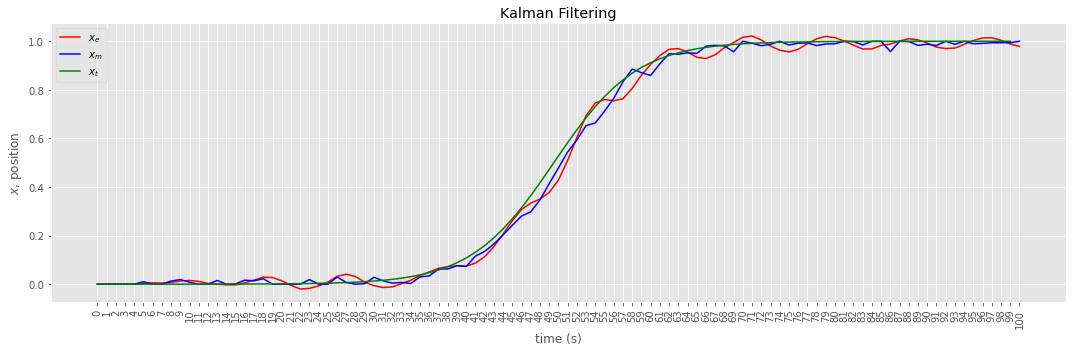

In [5]:
fig, ax = plt.subplots(figsize=(15, 5))

_ = data.pos_e.plot(kind='line', color='red', label=r'$x_e$', ax=ax)
_ = data.pos_m.plot(kind='line', color='blue', label=r'$x_m$', ax=ax)
_ = pd.Series(y_true).plot(kind='line', color='green', label=r'$x_t$', ax=ax)
_ = ax.set_xticks(data.index)
_ = ax.set_xticklabels(data.index, rotation=90)
_ = ax.legend()
_ = ax.set_xlabel('time (s)')
_ = ax.set_ylabel(r'$x$, position')
_ = ax.set_title('Kalman Filtering')

plt.tight_layout()

## Estimating PDF from CDF

Taking the average of the mean of the PDF and sample mean gives a better estimate of $\mu$.

In [6]:
from scipy.misc import derivative
from scipy.stats import norm

def get_quantile(p, cdf):
    try:
        return cdf[cdf <= p].idxmax()
    except:
        return np.NaN

x = np.linspace(-11, 11, 100)

@interact(x_0=(-4, 4, 1), k=(0.65, 1.5, 0.01))
def f(x_0=0, k=1.0):
    cdf = pd.Series(logistic(x, x_0=x_0, k=k), index=x)
    pdf = pd.Series(derivative(logistic, x, args=(x_0, k, 1)), index=x)
    samples = pd.Series(np.array([get_quantile(p, cdf) for p in np.random.random(size=5000)])).dropna()
    
    mu = (pdf.idxmax() + samples.mean()) / 2.0

    fig, ax1 = plt.subplots(figsize=(10, 3))
    ax2 = ax1.twinx()

    _ = cdf.plot(ax=ax1, color='blue', label='cdf')
    _ = pdf.plot(ax=ax2, color='green', label='pdf1')
    _ = samples.plot(kind='kde', ax=ax2, color='red', label='pdf2')
    _ = ax1.set_ylabel('cdf')
    _ = ax2.set_ylabel('pdf')
    _ = ax1.set_yticks(np.linspace(0, 1, 11))
    _ = ax2.legend()
    _ = ax1.set_title(fr'$\mu$={mu:.2f}, $\sigma$={samples.std():.2f}')

interactive(children=(IntSlider(value=0, description='x_0', max=4, min=-4), FloatSlider(value=1.0, description…

## Estimating curve parameters from normalized CDF

A lot of difficulties when you normalized $X$ into $[0, 1]$.

In [7]:
def get_raw_curve(x_0=0, k=1.0):
    x = np.linspace(-11, 11, 100)
    s = pd.Series(logistic(x, x_0=x_0, k=k), index=x)
    return s

def get_normalized_curve(r, delta=0.00001):
    s = r.copy(deep=True)
    # t = s[s <= delta].idxmax()
    # s = s[np.abs(s.index) >= t]
    s.index = list(range(s.shape[0]))
    s.index = s.index / (s.shape[0] - 1)
    s.iloc[0] = 0.0
    s.iloc[-1] = 1.0
    
    return s

def estimate_curve_params(s):
    x_e = np.median(s.index)
    k_e = 1.0
    L_e = 1.0

    p_0 = [x_e, k_e, L_e]
    popt, pcov = curve_fit(logistic, s.index, s.values, p_0, method='dogbox', maxfev=10000)
    return popt[0], popt[1]

def get_estimated_curve(x_0, k):
    x = np.linspace(0, 1, 100)
    s = pd.Series(logistic(x, x_0=x_0, k=k, L=1.0), index=x)
    return s

@interact(x_0=(-10, 10, 1), k=(0.65, 1.5, 0.01), xx_0=(-10, 10, 1), kk=(0.01, 1.5, 0.01))
def f(x_0=9, k=1.0, xx_0=10, kk=1.0):
    r = get_raw_curve(x_0=x_0, k=k)
    print('1. raw')
    n = get_normalized_curve(r)
    print('2. normalized')
    p = estimate_curve_params(n)
    print('3. parameter learning')
    s = get_estimated_curve(*p)
    print('4. estimated curve')
    m = get_normalized_curve(get_raw_curve(x_0=xx_0, k=kk))

    fig, ax = plt.subplots(figsize=(15, 3))

    _ = n.plot(ax=ax, alpha=0.2, color='red', label='normalized')
    _ = s.plot(ax=ax, alpha=0.2, color='green', label='estimated')
    _ = m.plot(ax=ax, alpha=0.2, color='blue', label='manual')

    _ = ax.set_yticks(np.linspace(0, 1, 11))
    _ = ax.set_xticks(np.linspace(0, 1, 11))
    _ = ax.legend()
    _ = ax.set_title(fr'{s.iloc[-1]:.5f}, $x_0$={p[0]:.5f}, $k$={p[1]:.5f}')

interactive(children=(IntSlider(value=9, description='x_0', max=10, min=-10), FloatSlider(value=1.0, descripti…

## Mixture modeling

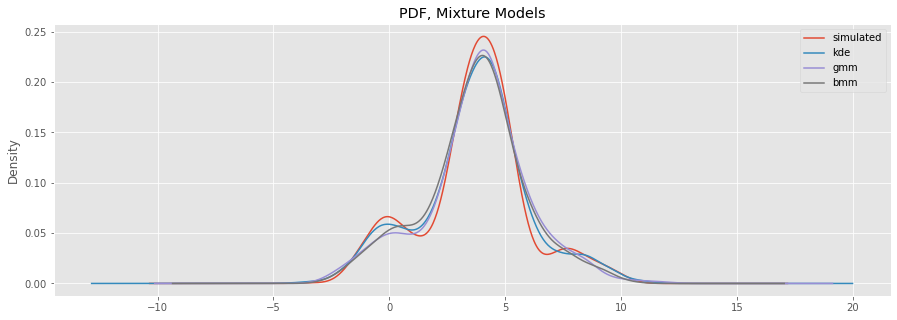

In [8]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

x = np.concatenate((
    norm.rvs(loc=0, scale=1, size=200), 
    norm.rvs(loc=4, scale=1, size=800),
    norm.rvs(loc=8, scale=1, size=100),
))

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(x.reshape(-1, 1))
gmm_pdf = lambda x: np.exp(kde.score(np.array([x]).reshape(-1, 1)))

gmm = GaussianMixture(n_components=3, max_iter=50, random_state=37)
bgm = BayesianGaussianMixture(n_components=3, max_iter=1000, random_state=37)

gmm.fit(kde.sample(10000))
bgm.fit(kde.sample(10000))

fig, ax = plt.subplots(figsize=(15, 5))

s_s = pd.Series(x)
s_k = pd.Series(kde.sample(10000).reshape(1, -1)[0])
s_g = pd.Series(gmm.sample(1000)[0][:,0])
s_b = pd.Series(bgm.sample(1000)[0][:,0])

_ = s_s.plot(kind='kde', bw_method='scott', ax=ax, label='simulated')
_ = s_k.plot(kind='kde', bw_method='scott', ax=ax, label='kde')
_ = s_g.plot(kind='kde', bw_method='scott', ax=ax, label='gmm')
_ = s_b.plot(kind='kde', bw_method='scott', ax=ax, label='bmm')
_ = ax.set_title('PDF, Mixture Models')
_ = ax.legend()

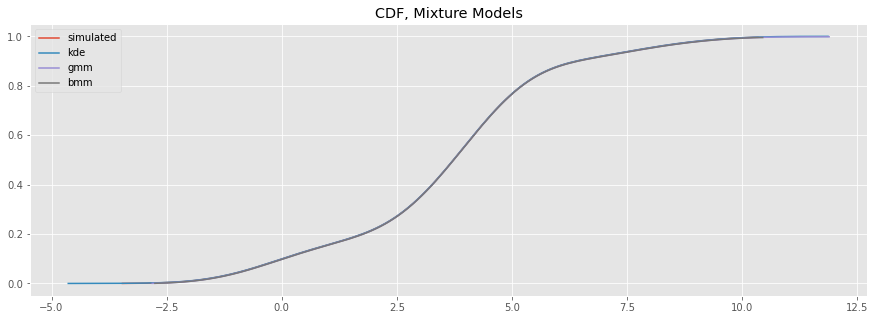

In [9]:
from scipy.integrate import quad

def get_cdf(s):
    x = np.arange(s.min(), s.max() + 0.1, 0.1)

    pairs = [(a, b) for a, b in zip(x, x[1:len(x)])]
    pairs = [quad(gmm_pdf, a, b) for a, b in pairs]
    points = np.array([tup[0] for tup in pairs] + [0])
    points = points.cumsum()

    cdf = pd.Series(points, index=x)
    return cdf

cdf_s = get_cdf(s_s)
cdf_k = get_cdf(s_k)
cdf_g = get_cdf(s_g)
cdf_b = get_cdf(s_b)

fig, ax = plt.subplots(figsize=(15, 5))

_ = cdf_s.plot(ax=ax, label='simulated')
_ = cdf_k.plot(ax=ax, label='kde')
_ = cdf_g.plot(ax=ax, label='gmm')
_ = cdf_b.plot(ax=ax, label='bmm')
_ = ax.set_title('CDF, Mixture Models')
_ = ax.legend()

In [10]:
p_s = cdf_s[cdf_s.index <= 5.0].max()
p_k = cdf_k[cdf_k.index <= 5.0].max()
p_g = cdf_g[cdf_g.index <= 5.0].max()
p_b = cdf_b[cdf_b.index <= 5.0].max()

print(p_s, p_k, p_g, p_b)

0.7574871246282715 0.7620978997496473 0.7643731387782752 0.7569689271330954


In [11]:
p_s = cdf_s[cdf_s <= 0.80].idxmax()
p_k = cdf_k[cdf_k <= 0.80].idxmax()
p_g = cdf_g[cdf_g <= 0.80].idxmax()
p_b = cdf_b[cdf_b <= 0.80].idxmax()

print(p_s, p_k, p_g, p_b)

5.139363814376653 5.1633632015131035 5.187557739169143 5.1448679310117225


## Find the best number of mixture components

In [48]:
from scipy.stats import ttest_ind

def sample_data():
    return np.concatenate((
        norm.rvs(loc=0, scale=1, size=200), 
        norm.rvs(loc=4, scale=1, size=800),
        norm.rvs(loc=8, scale=1, size=100)
    )).reshape(-1, 1)

def get_score(X, n_components, estimator='bgm'):
    if 'bgm' == estimator:
        mm = BayesianGaussianMixture(n_components=n_components, max_iter=1000, random_state=37)
    else:
        mm = GaussianMixture(n_components=n_components, max_iter=1000, random_state=37)
    
    mm.fit(X)
    s = 1 / -mm.score(X)
    return s

def get_scores(X, n_components, estimator='bgm'):
    return np.array([get_score(x, n_components, estimator) for x in X])

scores_prev = []
for n_components in range(1, 11):
    X = [sample_data() for _ in range(10)]
    scores_curr = get_scores(X, n_components, 'bgm')
    
    if len(scores_prev) > 0:
        _, p = ttest_ind(scores_prev, scores_curr)
        print(n_components, scores_prev.mean(), scores_curr.mean(), p)
        if p >= 0.05:
            print(n_components - 1)
            break
    
    scores_prev = scores_curr

2 0.44460258694041377 0.4510258491659279 0.00014525068376773263
3 0.4510258491659279 0.47286564533493347 1.5811367976876917e-10
4 0.47286564533493347 0.4744952133672446 0.33810528912917415
3


In [82]:
def sample_data(locs=[0, 4, 8], scales=[1, 1, 1], weights=[200, 600, 200]):
    return np.concatenate([norm.rvs(loc=loc, scale=scale, size=weight) 
                           for loc, scale, weight in zip(locs, scales, weights)]).reshape(-1, 1)

def get_mm(locs=[0, 4, 8], scales=[1, 1, 1], weights=[200, 600, 200], estimator='bgm'):
    n_components = len(locs)
    if 'bgm' == estimator:
        mm = BayesianGaussianMixture(n_components=n_components, max_iter=10000, random_state=37)
    else:
        mm = GaussianMixture(n_components=n_components, max_iter=10000, random_state=37)
    
    mm.fit(sample_data(locs, scales, weights))
    return mm

mm1 = get_mm(locs=[0, 4, 8])
mm2 = get_mm(locs=[3, 9, 15])
mm3 = get_mm(locs=[0.5, 5.5, 9.9])

In [102]:
cdf1 = get_cdf(mm1.sample(90000)[0][:,0])
cdf2 = get_cdf(mm2.sample(90000)[0][:,0])
cdf3 = get_cdf(mm3.sample(90000)[0][:,0])

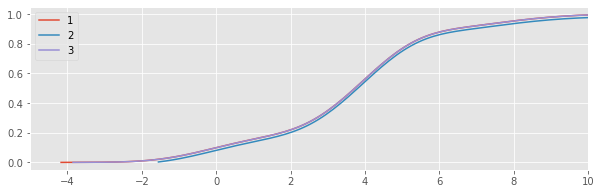

In [105]:
fig, ax = plt.subplots(figsize=(10, 3))

cdf1.plot(ax=ax, label='1')
cdf2.plot(ax=ax, label='2')
cdf3.plot(ax=ax, label='3')

ax.set_xlim([-5, 10])
ax.legend()

In [117]:
cdf3

-3.849431     0.000058
-3.749431     0.000125
-3.649431     0.000202
-3.549431     0.000293
-3.449431     0.000400
                ...   
 13.550569    0.999698
 13.650569    0.999698
 13.750569    0.999698
 13.850569    0.999698
 13.950569    0.999698
Length: 179, dtype: float64